In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Matrix factorization through vanilla SCA

In [3]:
def MF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L))
    W = np.ones((L,n))

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)

    for _ in tqdm(range(max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [4]:
A = np.random.normal(size = (1500,2000))
A /= np.linalg.norm(A, axis = 0)

In [5]:
(V,W), D = MF_SCA(A,1000)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


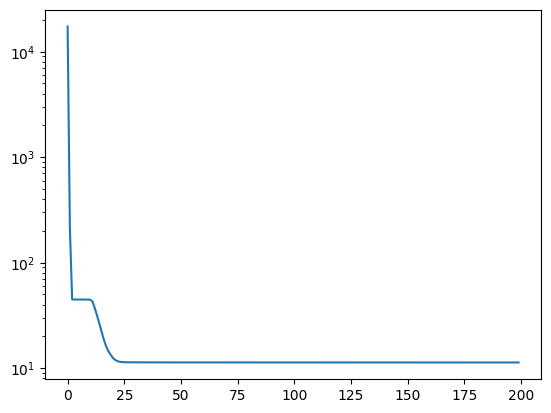

In [6]:
plt.plot(D)
plt.yscale('log')

In [7]:
np.linalg.norm(V @ W - A, ord='fro')

11.31446112612937

### Neural Building Blocks design - Deep Matrix Factorization

In [35]:
# Model for optimizing wrt V 

M = 150
N = 200
L = 70

A = torch.randn(M, N)
V = torch.randn(M, L)
W = torch.randn(L, N)

In [67]:
class ModuleV(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.1, weight_decay = 5e-4)

    def forward(self, W):
        return self.V @ W
    
    def emit(self):
        return self.V

    def loss(self, A, W):
        return torch.linalg.norm(A - self.forward(W), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(W), 'fro')

    def step(self, A, W):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, W)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, W):
        for _ in range(self.t):
            self.step(A, W)

    def reset(self):
        self.V = nn.Parameter(torch.randn(self.M, self.L)*0.01, requires_grad=True)


In [68]:
class ModuleW(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.1, weight_decay = 5e-4)

    def forward(self, V):
        return V @ self.W
    
    def emit(self):
        return self.W
    
    def loss(self, A, V):
        return torch.linalg.norm(A - self.forward(V), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(V), 'fro')
    
    def step(self, A, V):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, V)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, V):
        for _ in range(self.t):
            self.step(A, V)
    
    def reset(self):
        self.W = nn.Parameter(torch.randn(self.L, self.N)*0.01, requires_grad=True)


In [69]:
class DeepMatrixFactorization(nn.Module):
    def __init__(self, M, L, N, lambda_ = 0.5, gamma = 0.99, T = 50, t = 100):

        self.M = M
        self.L = L
        self.N = N

        self.T = T
        self.t = t

        self.lambda_ = lambda_
        self.gamma = gamma

        self.blocks = []
        self.gammas = []

        for t in range(self.T):
            self.blocks.append({
                'Block V': ModuleV(self.M, self.L, self.N, self.lambda_, self.t),
                'Block W': ModuleW(self.M, self.L, self.N, self.lambda_, self.t)
            })

            self.gammas.append(self.gamma * (0.99 ** self.t))
        
        self.losses = []

    def inference(self, A): 
        
        V = torch.randn(self.M, self.L)
        W = torch.randn(self.L, self.N)

        for t in tqdm(range(self.T)):
            
            self.blocks[t]['Block V'].learn(A, W)
            self.blocks[t]['Block W'].learn(A, V)

            V = V + self.gammas[t]*(self.blocks[t]['Block V'].emit() - V)
            W = W + self.gammas[t]*(self.blocks[t]['Block W'].emit() - W)

            self.blocks[t]['Block V'].reset()
            self.blocks[t]['Block W'].reset()

            self.losses.append((torch.linalg.norm(A - V @ W, 'fro')).detach().numpy())
        
        return V, W


In [70]:
model = DeepMatrixFactorization(M, L, N, lambda_ = 0.05)

In [71]:
V_, W_ = model.inference(A)

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


In [72]:
_, D2 = MF_SCA(A.detach().numpy(),L,max_iter=50)

100%|██████████| 50/50 [00:00<00:00, 180.79it/s]


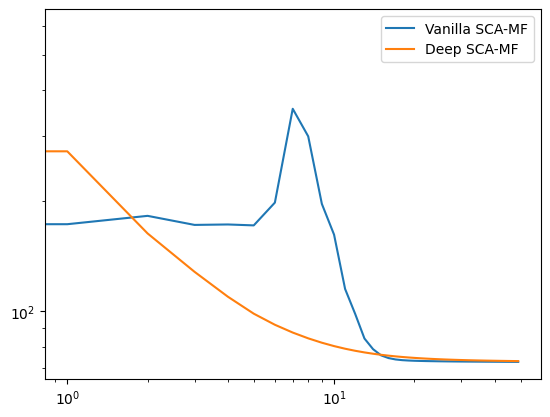

In [73]:
plt.loglog(D2, label='Vanilla SCA-MF')
plt.loglog(model.losses, label= 'Deep SCA-MF')
plt.legend()

__________